<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/qml/quantum_kernel_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install -q qiskit-aer
!pip install -q qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from pylab import cm
from sklearn import metrics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

<ipython-input-2-1aeb51c584ab>:11: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA


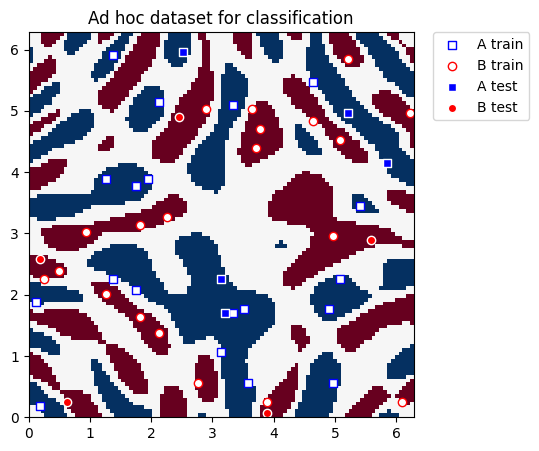

In [3]:
adhoc_dimension = 2
X_train, y_train, X_test, y_test, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    X_train[np.where(y_train[:] == 0), 0],
    X_train[np.where(y_train[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    X_train[np.where(y_train[:] == 1), 0],
    X_train[np.where(y_train[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    X_test[np.where(y_test[:] == 0), 0],
    X_test[np.where(y_test[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    X_test[np.where(y_test[:] == 1), 0],
    X_test[np.where(y_test[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

#### Define the Quantum Feature Map

In [4]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
training_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(2)
fm0.ry(training_params[0], 0)
fm0.ry(training_params[0], 1)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(2)

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {training_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [5]:
# Instantiate quantum kernel
quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

In [6]:
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 2.30505600447818},
    'optimal_point': array([2.305056]),
    'optimal_value': 11.940906389851364,
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7eef32524820>}


In [7]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 1.0


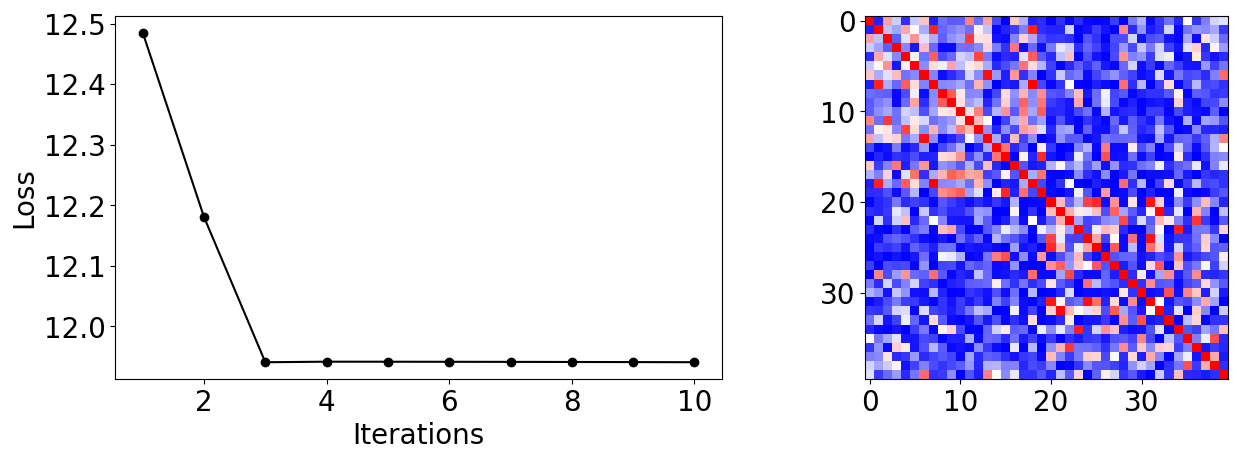

In [8]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
fig.tight_layout()
plt.show()